In [1]:
# - megcsinálni, hogy éjjel is fusson amikor nem megy a notebook és utána ki tudjam elemezni az egészet

# - ezáltal több vm-n is tudom majd futtatni különböző beállításokkal

# - beletenni indiket

# - megoldani a normalizálást (hogy legalább kb -1, 1 között legyen minden)

# - ha ez megvan akkor jöhet majd az hogy átteszem kerasba
#   - kérdés hogy gyorsabb lesz-e?
#   - meg tudom csinálni cnnre és ez a lényeg


# kedvenc tutorialom
# https://www.programiz.com/python-programming/package

In [2]:
import os
import sys
import glob
import keras
import pprint
import sklearn
import ipywidgets
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPRegressor

from keras.models import Sequential
from keras.layers import Dense, Activation

from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Checkbox
from IPython.display import display

from matplotlib.ticker import StrMethodFormatter
from matplotlib import cm

import time
import talib
import random
import joblib
from sys import maxsize

import importlib

print('Python version:{}'.format(sys.version))
print('Numpy version:{}'.format(np.__version__))
print('Pandas version:{}'.format(pd.__version__))
print('Keras version:{}'.format(keras.__version__))
print('Tensorflow version:{}'.format(tf.__version__))
print('Sci-Kit Learn version:{}'.format(sklearn.__version__)) 

2023-02-18 10:03:55.023038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 10:03:55.173600: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-18 10:03:55.184212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-18 10:03:55.184239: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Python version:3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
Numpy version:1.23.5
Pandas version:1.3.5
Keras version:2.10.0
Tensorflow version:2.10.0
Sci-Kit Learn version:1.0.2


In [45]:
import modules.datareader
from modules.datareader import DataReader

import modules.experiment
from modules.experiment import Experiment

import modules.nn
from modules.nn import NN, KerasMLP

import modules.trader
from modules.trader import Trader

import modules.randomer
from modules.randomer import Randomer

import modules.plotter
from modules.plotter import Plotter


import modules.fuk
from modules.fuk import plot_trade_adv
from modules.fuk import create_animated_mp4
from modules.fuk import save_model_trader_results
from modules.fuk import run_info

def reload():
    importlib.reload(modules.datareader)
    importlib.reload(modules.nn)
    importlib.reload(modules.fuk)
    importlib.reload(modules.trader)
    importlib.reload(modules.plotter)
    importlib.reload(modules.experiment)

reload()

There are 24000 rows and 12 columns
         Date   Time      BO      BH      BL      BC  BCh      AO      AH  \
0  2005-01-02  18:29  1.3555  1.3555  1.3555  1.3555  0.0  1.3565  1.3565   
1  2005-01-02  18:38  1.3555  1.3555  1.3555  1.3555  0.0  1.3565  1.3565   
2  2005-01-02  18:51  1.3562  1.3562  1.3562  1.3562  0.0  1.3572  1.3572   
3  2005-01-02  18:52  1.3560  1.3560  1.3560  1.3560  0.0  1.3570  1.3570   
4  2005-01-02  18:55  1.3563  1.3563  1.3563  1.3563  0.0  1.3573  1.3573   

       AL      AC  ACh  
0  1.3565  1.3565  0.0  
1  1.3565  1.3565  0.0  
2  1.3572  1.3572  0.0  
3  1.3570  1.3570  0.0  
4  1.3573  1.3573  0.0  
------------------------------------------------------------------------------
(24000, 12)
(24000, 1)
(24000, 1)
------------------------------------------------------------------------------
(24000, 1)
(24000,)
(24000, 1)
indcator section
------------------------------------------------------------------------------
Set window = 10
----------------

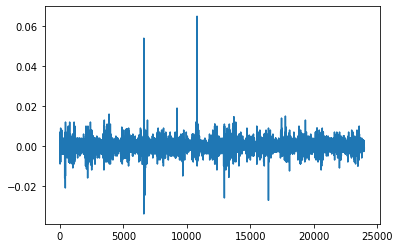

In [46]:
ROW = 24000
FROM = 0
DIFF_MULTIPLIER = 10
INPUT_MULTIPLIER = 10

WINDOW = 10

data_reader = DataReader(nRowsRead=ROW)
data_reader.load_with_pandas(path = './input/eurusd_minute.csv') 
data_reader.cut(FROM, ROW)
#data_reader.info()
# data_reader.df.info()
data_reader.set_target()
# data_reader.show_array_info()
data_reader.create_diff(DIFF_MULTIPLIER)
data_reader.remove_price()
data_reader.input = data_reader.input * INPUT_MULTIPLIER
data_reader.create_indicators()
data_reader.set_window(WINDOW)
data_reader.create_train_set()
data_reader.create_test_set()


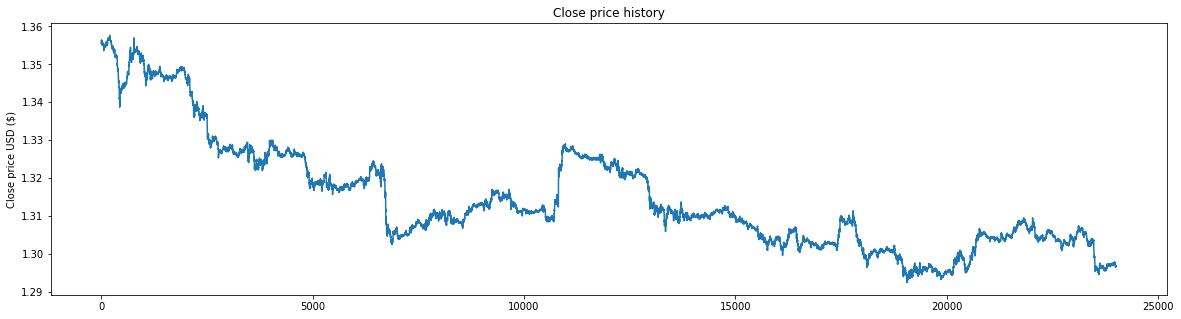

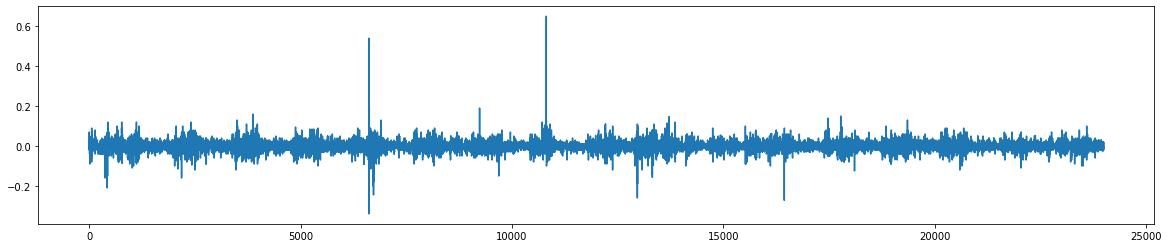

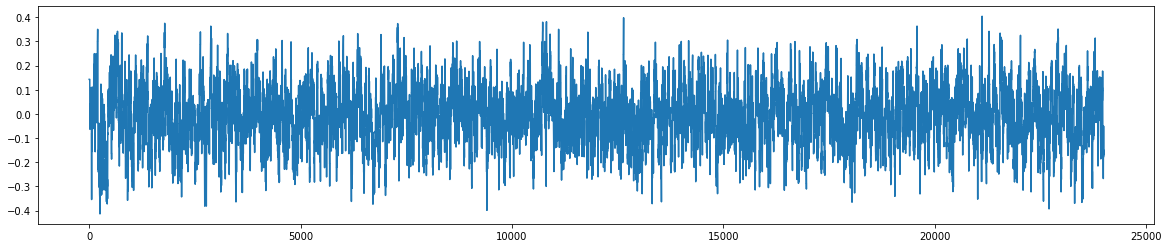

In [47]:
plt.figure(figsize=(20,5))
plt.title('Close price history')
plt.plot(data_reader.array)
plt.ylabel('Close price USD ($)')
plt.show()

for i in range(data_reader.input.shape[-1]):
    plt.figure(figsize=(20, 4))
    plt.plot(data_reader.input[:, i])

    1440 perc egy nap -> 14400 perc -> 10 nap 28800 -> 20 nap
    
    szóval 28K az még mindíg csak 20 nap az nem olyan sok, de még ezen sem tudom ránevelni, hogy rásimuljon

In [48]:

FIRST = 10
SECOND = 5

# ------------------------------------------------------------------------------

# Scikit
nn = NN(x_train = data_reader.x_train, y_train = data_reader.y_train)
nn.init_nn(_first = FIRST, _second = SECOND, activation='tanh')

# nn.mlp.coefs_                                                                     # <-- ha debuggolni kell

# ------------------------------------------------------------------------------

# Keras
kn = KerasMLP(x_train = data_reader.x_train, y_train = data_reader.y_train)
kn.init_nn(_first = FIRST, _second = SECOND, activation='tanh')

# kn.mlp.get_weights()                                                              # <-- ha debuggolni kell

# ------------------------------------------------------------------------------

_ = nn.knn_to_snn(kn)



## Program

__init__ Trader


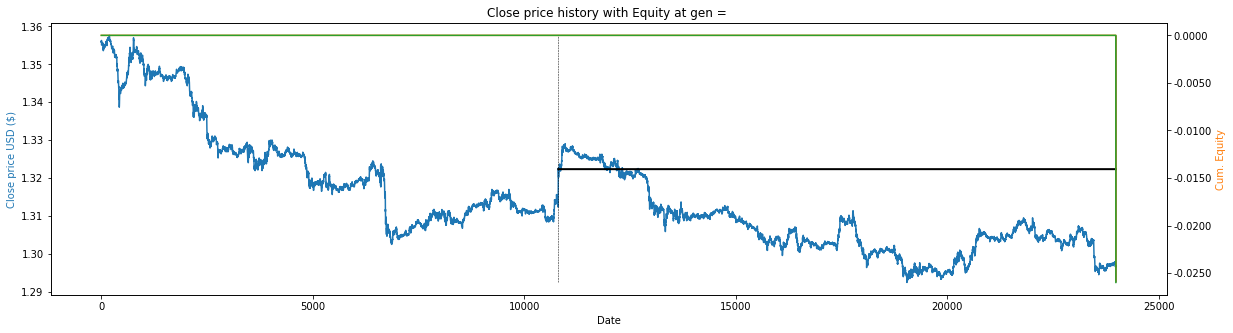

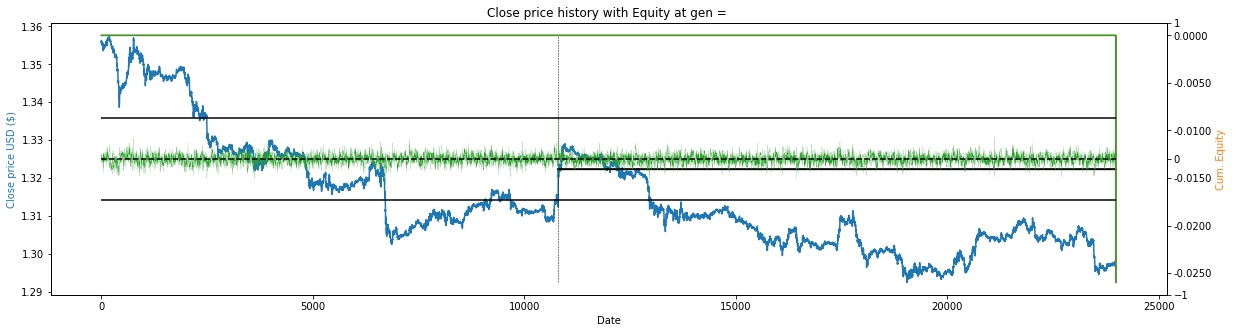

{'buy_count': 1, 'sell_count': 1, 'gain': -0.025979999999999955}


In [49]:
TRADE_COST = 0.0005                  # jelenleg a minimális költég 5x adtam az igazinak -> erős
TRADE_COST = 0.000160
MINIMALMOV = 0.000010
MINTPROFIT = 0.000160
DYNASPREAD = 0.000080                # a spread a minimal movenak a 8x
THRESHOLD = 0.0
TH = 0.3

trader = Trader(threshold=THRESHOLD,
                data_reader=data_reader,
                trade_cost=TRADE_COST,
                th=TH)


pred = nn.create_prediction()
result = trader.calculator_np(pred)

plot_trade_adv(trader, window=trader.window)
plot_trade_adv(trader, trader_signal=pred, window=trader.window)

print(result)
# trader.result



In [50]:
# nn.mlp.activation = 'tanh'
# nn.mlp.hidden_layer_sizes = (4)

nn.mlp.get_params()

{'activation': 'tanh',
 'alpha': 0.0001,
 'batch_size': 9900000,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (10, 5),
 'learning_rate': 'constant',
 'learning_rate_init': 1e-10,
 'max_fun': 15000,
 'max_iter': 1,
 'momentum': 0.9,
 'n_iter_no_change': 99999999,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': False,
 'solver': 'sgd',
 'tol': 0.0001,
 'validation_fraction': 0.0,
 'verbose': False,
 'warm_start': False}

In [51]:
ex = Experiment(data_reader, nn)

In [58]:

conf = dict()
conf['TRADE_COST'] = 0.000160 # 0.0005
conf['THRESHOLD']  = 0.0
conf['TH']         = 0.3

conf['internal_plotting'] = True
conf['repeatable']        = False
conf['re_learn']          = True

conf['generation']        = 2000
conf['population']        = 20
conf['factor_weight']     = 100
conf['factor_intercept']  = 200
conf['variable_factor']   = True
conf['factor_min']        = 0.1
conf['factor_max']        = 15
conf['keep_best']         = True
conf['select_ratio_weight']   = 1
conf['select_ratio_bias']     = 1
conf['variable_select_ratio'] = True
conf['select_ratio_min']      = 0.1
conf['select_ratio_max']      = 0.9

ex.exp(conf)

create_animated_mp4('price*.png', framerate=1, quite=True)


__init__ Trader
0
new best_solution find individual =  0
i = 0 j = 0 	score =  0.021210000000000243
best_score in generation i =  0  =  0.021210000000000243
(array([  1,  94, 148, 181]), array([3, 1, 1, 1]))
new best_solution find individual =  14
i = 29 j = 14 	score =  0.024479999999999995
best_score in generation i =  29  =  0.024479999999999995
100
200
300
400
500
(array([ 1,  2,  3,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 35, 37, 38, 39, 41, 42,
       44, 45, 47, 50, 60, 63, 69, 89]), array([6, 2, 2, 1, 2, 1, 1, 3, 5, 5, 2, 3, 6, 3, 5, 3, 3, 1, 6, 1, 3, 3,
       1, 3, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]))
new best_solution find individual =  1
i = 588 j = 1 	score =  0.02617999999999987
best_score in generation i =  588  =  0.02617999999999987
600
700
800
900
new best_solution find individual =  3
i = 924 j = 3 	score =  0.02674999999999975
best_score in generation i =  924  =  0.026749999999999

<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>
<class 'modules.trader.Trader'>
<class 'list'>
457.1980 sec 	 total time
117.2928 sec 	 mlp pred
4.6712 sec 	 randomer
335.0825 sec 	 trader


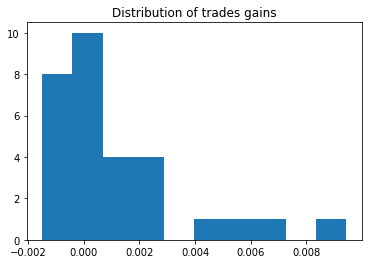

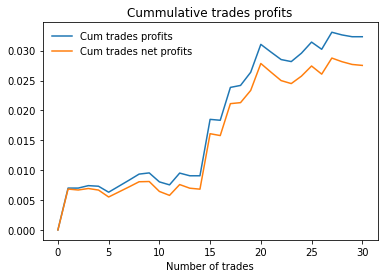

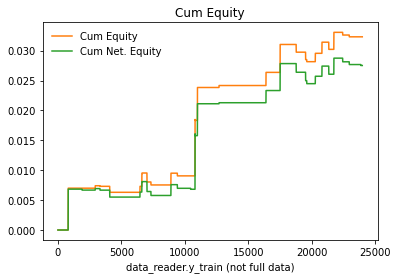

In [59]:
trader = ex.trader
trader.result

# save model
save_model_trader_results(ex)

# shor ex runtime info
run_info(ex)

# create plotter
plotter = Plotter(trader.result)

# plot result
plotter.plot_res(trader)


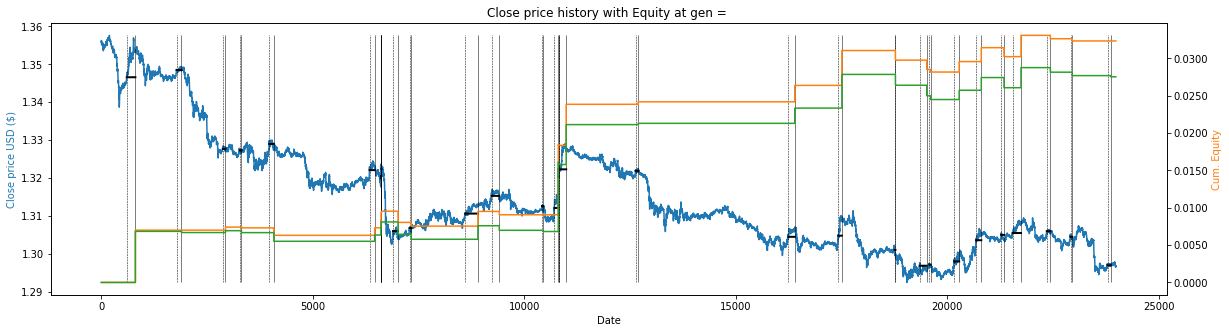

In [60]:

plot_trade_adv(trader, _from=0, _back=0, window=trader.window, step=True)


In [61]:
_from   = IntSlider(min=0, max=12000, step=1, value=0, description='start')
_back   = IntSlider(min=0, max=12000, step=1, value=0, description='back')
_window = IntSlider(min=-10, max=trader.window, step=1, value=trader.window, description='window')
_step   = Checkbox(value=True, description='step')
_trd    = fixed(trader)

ui = ipywidgets.HBox([_from, _back, _window, _step])
params = {'trader': _trd, '_from': _from, '_back': _back, 'window': _window, 'step': _step}
out = ipywidgets.interactive_output(plot_trade_adv, params)
display(ui, out)

Output()

[[  603]
 [  613]
 [  654]
 [  658]
 [  679]
 [  684]
 [  765]
 [  766]
 [  770]
 [ 1781]
 [ 2877]
 [ 2884]
 [ 3273]
 [ 3972]
 [ 3979]
 [ 6345]
 [ 6610]
 [ 6614]
 [ 6624]
 [ 6897]
 [ 6901]
 [ 6905]
 [ 7289]
 [ 7290]
 [ 7292]
 [ 7298]
 [ 8603]
 [ 9229]
 [10422]
 [10711]
 [10719]
 [10721]
 [10722]
 [10724]
 [10726]
 [10811]
 [10820]
 [10824]
 [10827]
 [10832]
 [10897]
 [10901]
 [10905]
 [12636]
 [16246]
 [17428]
 [17478]
 [18757]
 [19350]
 [19354]
 [19581]
 [20166]
 [20684]
 [21279]
 [21286]
 [21548]
 [22356]
 [22919]
 [23796]]


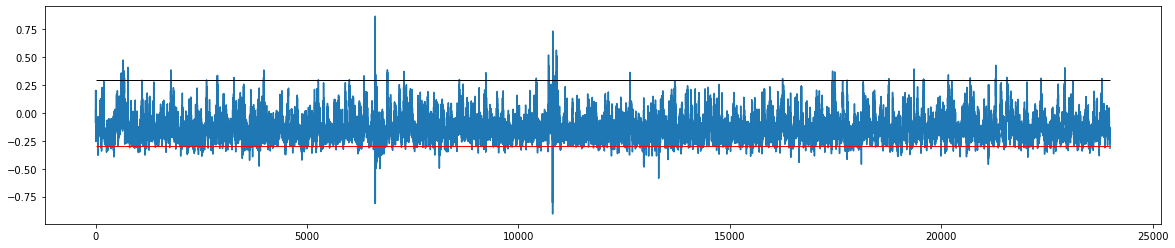

In [62]:
# ToDo: ezt bebaszni a plotter osztályba (signál és a thresholdok)

plt.figure(figsize=(20, 4))
plt.plot(ex.test_pred)
_x_max = ex.test_pred.shape[0]
plt.hlines(trader.th_dn, 0, _x_max, lw=1.0, color='red')
plt.hlines(trader.th_up, 0, _x_max, lw=1.0, color='black')
print(np.argwhere(ex.test_pred > ex.trader.th_up))
plt.show()

Output()

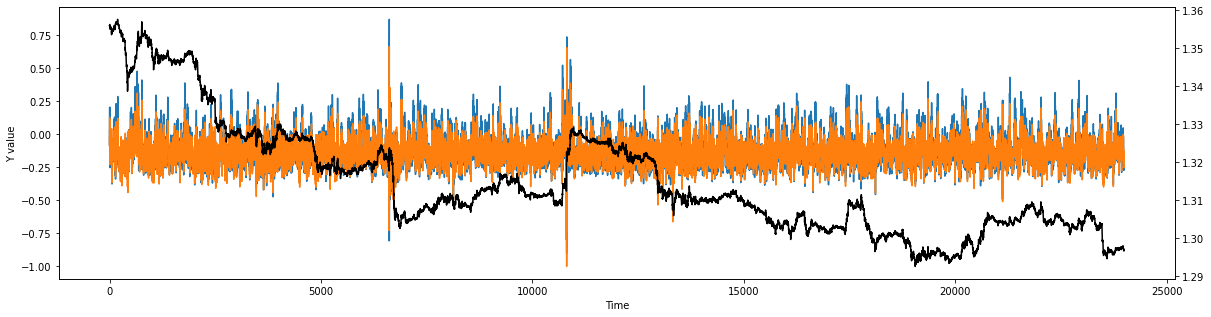

In [64]:
start = IntSlider(min=0, max=12000, step=1, value=0, description='start')
end   = IntSlider(min=-14000, max=-1, step=1, value=1, description='end')

p     = Checkbox(description='predicted', value=True)
i     = Checkbox(description='initial', value=True)

d     = fixed(data_reader)
e     = fixed(ex)

params = {'data_reader': d, 'ex': e, 'start': start, 'end': end, 'p': p, 'i': i}

ui = ipywidgets.HBox([start, end, p, i])
out = ipywidgets.interactive_output(plotter.plot_int, params)
display(ui, out)


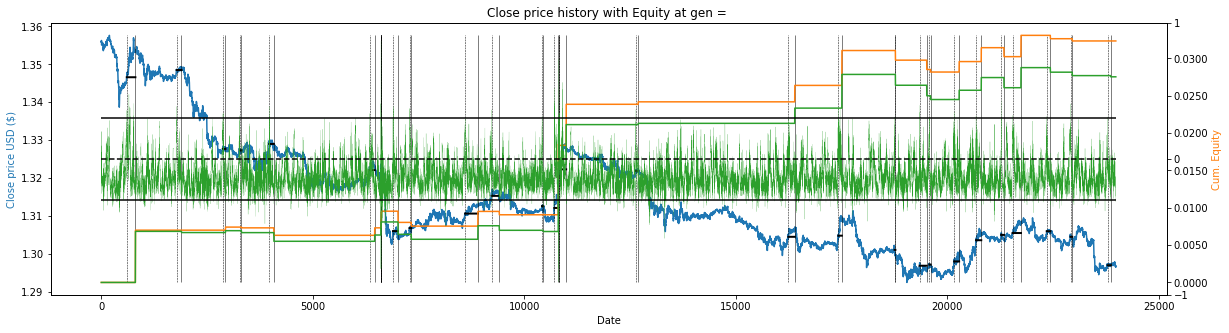

In [65]:
plot_trade_adv(trader, trader_signal=ex.test_pred, window=trader.window, _from=0, _back=0)

## Visualise net - Best Solution

[20 10  5  1]


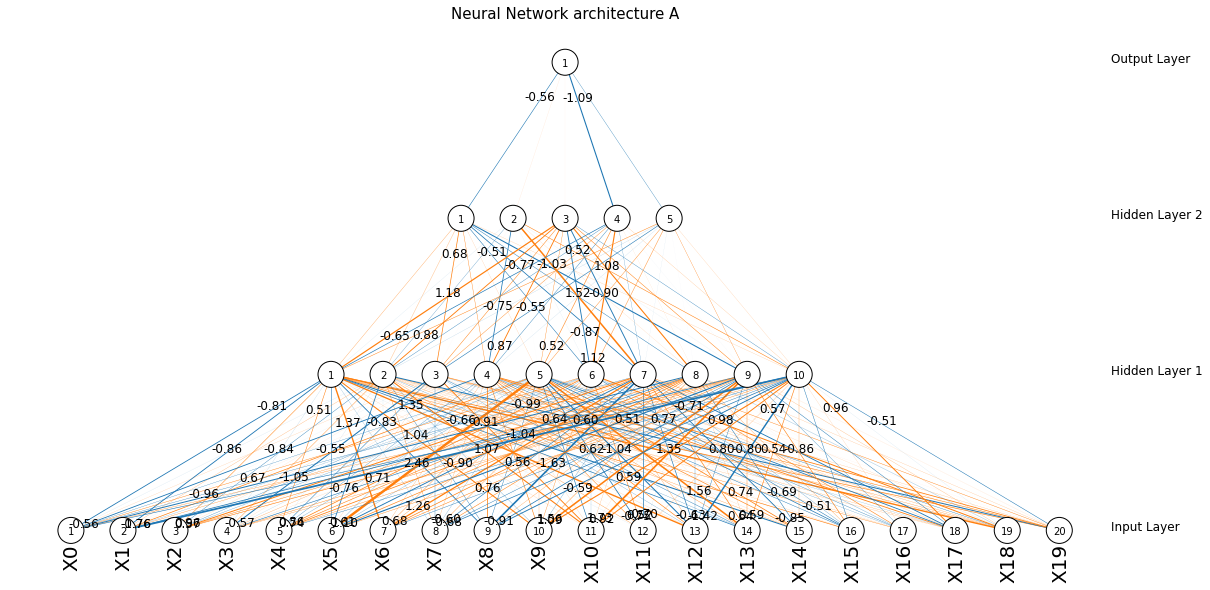

In [66]:
plotter.vshow(ex.result['best_generation_solution'])

## Visualise net - Initial ('Empty') Solution

[20 10  5  1]


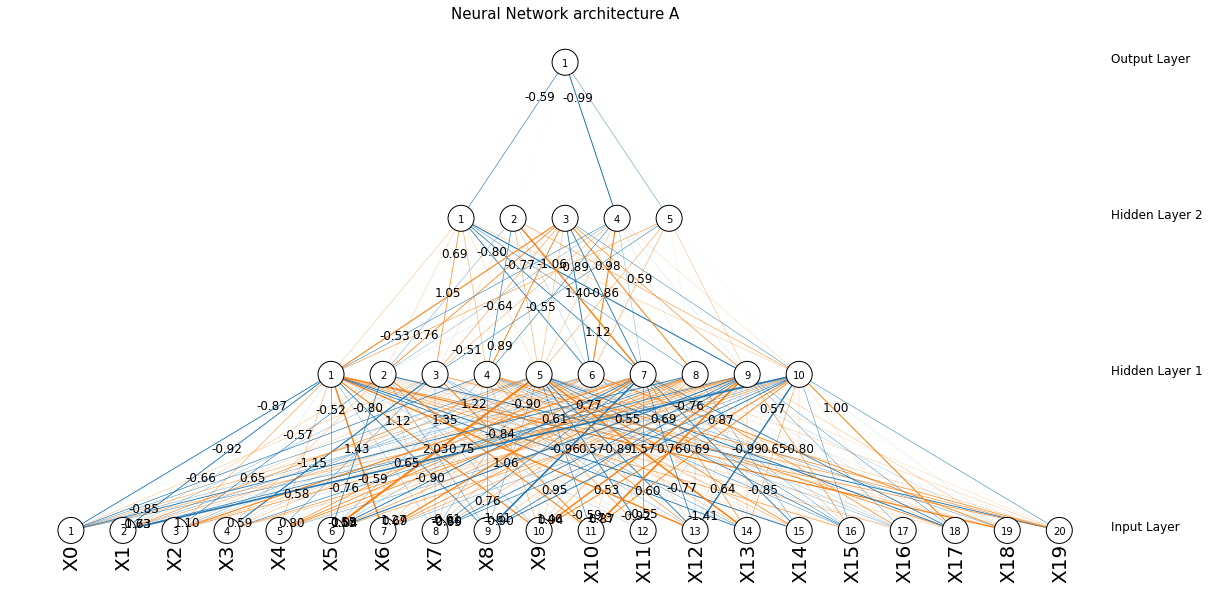

In [67]:
plotter.vshow(ex.attach['backup_mlp'])


```
# JoDeMiro
```


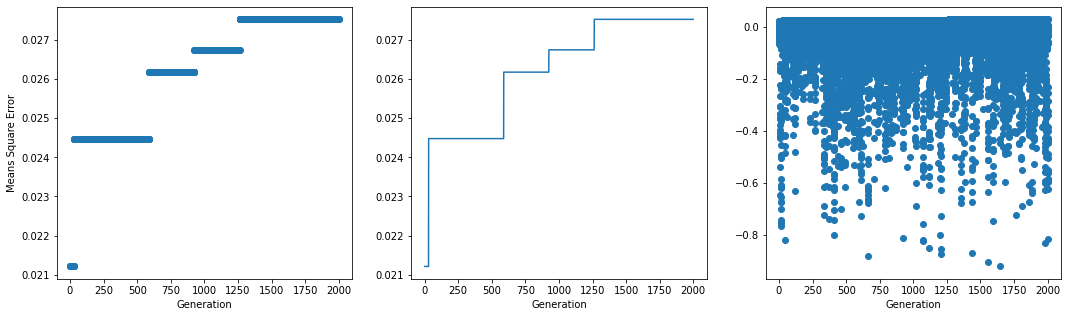

In [68]:
plotter = Plotter(ex.result)

plotter.plot_results(2000, True)

In [69]:
_max = IntSlider(min=40, max=800, step=1, value=120)

interact(plotter.plot_results, _max=_max, _show_mid=True, _show_avg=True);

interactive(children=(IntSlider(value=120, description='_max', max=800, min=40), Checkbox(value=True, descript…

In [70]:

# meg van minden -> nézzük meg milyen lépéseket kell tennem ahoz, hogy a test adatokon is lefusson


## Test the model on extended data

Experimental

Sajnos a normalizáció miatt el fog csúszni, ezért az lenne az igazi, hogy ha a normalizációt nem csinálnám meg rajta.

There are 935000 rows and 12 columns
         Date   Time      BO      BH      BL      BC  BCh      AO      AH  \
0  2005-01-02  18:29  1.3555  1.3555  1.3555  1.3555  0.0  1.3565  1.3565   
1  2005-01-02  18:38  1.3555  1.3555  1.3555  1.3555  0.0  1.3565  1.3565   
2  2005-01-02  18:51  1.3562  1.3562  1.3562  1.3562  0.0  1.3572  1.3572   
3  2005-01-02  18:52  1.3560  1.3560  1.3560  1.3560  0.0  1.3570  1.3570   
4  2005-01-02  18:55  1.3563  1.3563  1.3563  1.3563  0.0  1.3573  1.3573   

       AL      AC  ACh  
0  1.3565  1.3565  0.0  
1  1.3565  1.3565  0.0  
2  1.3572  1.3572  0.0  
3  1.3570  1.3570  0.0  
4  1.3573  1.3573  0.0  
------------------------------------------------------------------------------
(932000, 12)
(932000, 1)
(932000, 1)
------------------------------------------------------------------------------
(932000, 1)
(932000,)
(932000, 1)
indcator section
------------------------------------------------------------------------------
Set window = 10
---------

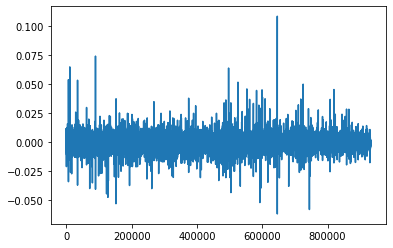

In [71]:

test_data_reader = DataReader(nRowsRead=935000)                                 # <-- instantiate DataReader (set number of rows for data)

test_data_reader.load_with_pandas(path = './input/eurusd_minute.csv')           # <-- read a particular files from disk (return with df, but also set self)

test_data_reader.cut(0, 932000)                                                 # <-- cut from to (start, to)

# test_data_reader.info()                                                       # <-- my own info() function

# test_data_reader.df.info()                                                    # <-- call pandas built-in info() function

test_data_reader.set_target()                                                   # <-- prepare is setter convert pandas to numpy and set target variable

# test_data_reader.show_array_info()

test_data_reader.create_diff(DIFF_MULTIPLIER)        # innentől self.input

test_data_reader.remove_price()

test_data_reader.input = test_data_reader.input * INPUT_MULTIPLIER

test_data_reader.create_indicators()

# test_data_reader.normalize_values()                                           # <-- transform data between range (-1,1)

test_data_reader.set_window(ex.data_reader.window)                                                      # <-- set window size

test_data_reader.create_train_set()                                             # <-- prepare egyik legfontossab metódusa (sok transzformációval)


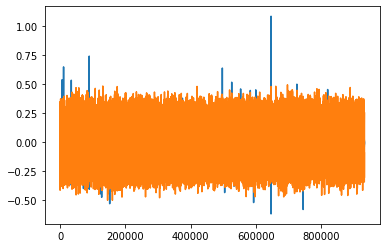

In [72]:
for i in range(test_data_reader.input.shape[-1]):
    plt.plot(test_data_reader.input[:, i])

In [73]:
conf

{'TRADE_COST': 0.00016,
 'THRESHOLD': 0.0,
 'TH': 0.3,
 'internal_plotting': True,
 'repeatable': False,
 're_learn': True,
 'generation': 2000,
 'population': 20,
 'factor_weight': 100,
 'factor_intercept': 200,
 'variable_factor': True,
 'factor_min': 0.1,
 'factor_max': 15,
 'keep_best': True,
 'select_ratio_weight': 1,
 'select_ratio_bias': 1,
 'variable_select_ratio': True,
 'select_ratio_min': 0.1,
 'select_ratio_max': 0.9}

In [74]:
TRADE_COST = 0.0005
THRESHOLD  = None
TH = None

TRADE_COST = conf['TRADE_COST']
THRESHOLD  = conf['THRESHOLD']
TH = conf['TH']

print(TH)
print(TRADE_COST)

trader = Trader(threshold=THRESHOLD,
                data_reader=test_data_reader,
                trade_cost=TRADE_COST,
                th=TH,
                debug=False)

0.3
0.00016
__init__ Trader


In [75]:
# A globalisan legjobb megoldás alapján csináljuk meg a becslést
test_pred = ex.result['best_generation_solution'].predict(
    test_data_reader.x_train)  # <-- kiértékeléshez és vizualizációhoz

# Végül minden esetben updateljük a trader.result-ot azáltal, hogy meghívjuk a következőt
replayed_result = trader.calculator_np(test_pred)

replayed_result

{'buy_count': 1119, 'sell_count': 1119, 'gain': -0.020669999999998415}

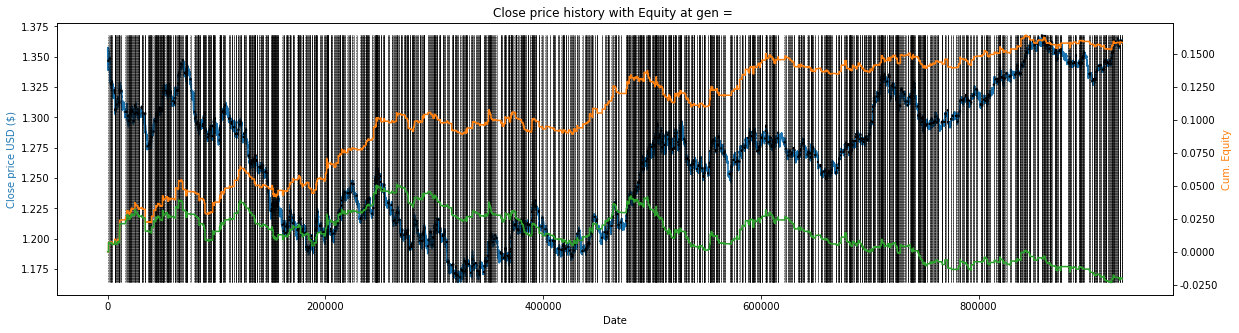

In [76]:

plot_trade_adv(trader, _from=0, _back=0, window=trader.window, step=True)


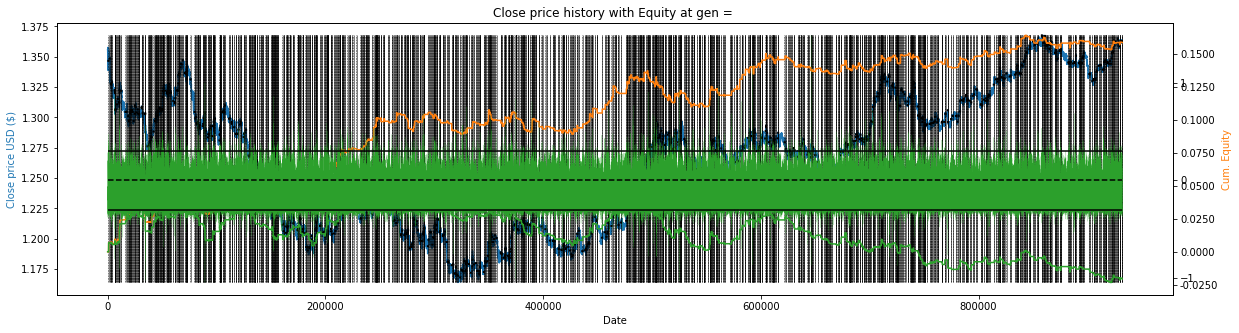

In [77]:

plot_trade_adv(trader, trader_signal=test_pred, window=trader.window, _from=0, _back=0)


In [41]:
trader.trade_cost

0.00016

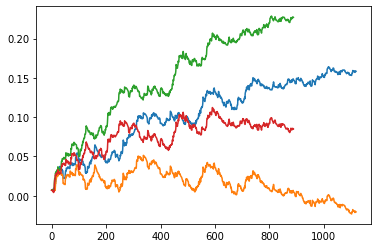

In [78]:
# nincs rajta a kötési költség azért tündököl ilyen szépen

trader.result.keys()
_raw_eq = np.cumsum(trader.result['sell_price']-trader.result['buy_price'])
plt.plot(_raw_eq)

_net_eq = np.cumsum(trader.result['sell_price']-trader.result['buy_price']-trader.trade_cost)
plt.plot(_net_eq)

#leveszem a nagyon rövid tradeket
_min = 30
_raw_eq_min = np.cumsum(trader.result['sell_price'][trader.result['trade_length'] > _min] - 
              trader.result['buy_price'][trader.result['trade_length'] > _min])
plt.plot(_raw_eq_min)

_net_eq_min = np.cumsum(trader.result['sell_price'][trader.result['trade_length'] > _min] - 
              trader.result['buy_price'][trader.result['trade_length'] > _min] - trader.trade_cost)
plt.plot(_net_eq_min)
# sajnos a rövid tradek adnak sok profitot

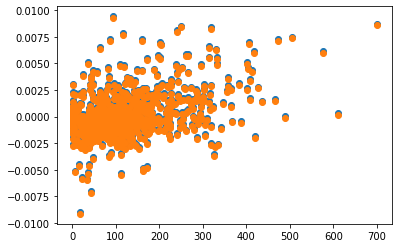

In [79]:
# profit tradenként és tradek hossz aközötti öszfüg

t_raw_prof = trader.result['sell_price'] - trader.result['buy_price']
t_net_prof = trader.result['sell_price'] - trader.result['buy_price'] - trader.trade_cost
tlen  = trader.result['trade_length']
plt.scatter(tlen, t_raw_prof)
plt.scatter(tlen, t_net_prof)

(array([  1.,   4.,  11.,  84., 643., 253.,  77.,  25.,  15.,   6.]),
 array([-9.160e-03, -7.316e-03, -5.472e-03, -3.628e-03, -1.784e-03,
         6.000e-05,  1.904e-03,  3.748e-03,  5.592e-03,  7.436e-03,
         9.280e-03]),
 <BarContainer object of 10 artists>)

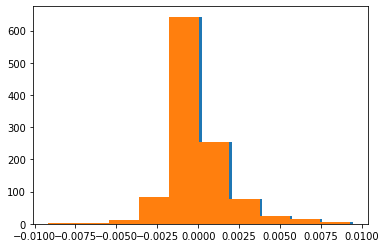

In [80]:
# jó lenne látni a profit eloszlását is

plt.hist(t_raw_prof)
plt.hist(t_net_prof)

(array([[  1.,   3.,   5.,  37., 353.,  80.,  15.,   4.,   1.,   0.],
        [  0.,   1.,   2.,  33., 200.,  83.,  18.,   3.,   1.,   2.],
        [  0.,   0.,   3.,   7.,  55.,  47.,  20.,   6.,   4.,   0.],
        [  0.,   0.,   0.,   1.,  23.,  25.,  10.,   5.,   2.,   2.],
        [  0.,   0.,   1.,   5.,   9.,  13.,   6.,   4.,   2.,   1.],
        [  0.,   0.,   0.,   0.,   2.,   2.,   7.,   3.,   2.,   0.],
        [  0.,   0.,   0.,   1.,   1.,   2.,   1.,   0.,   1.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]]),
 array([  1. ,  70.9, 140.8, 210.7, 280.6, 350.5, 420.4, 490.3, 560.2,
        630.1, 700. ]),
 array([-0.009   , -0.007156, -0.005312, -0.003468, -0.001624,  0.00022 ,
         0.002064,  0.003908,  0.005752,  0.007596,  0.00944 ]),
 <matplotlib.collections.QuadMesh at 0x7f3694344130>)

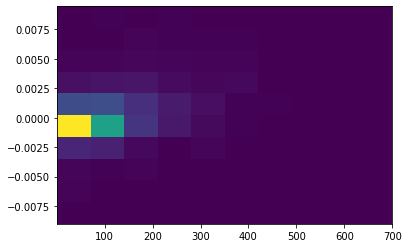

In [81]:
plt.hist2d(tlen, t_raw_prof)

In [82]:
vetel = 1.07022
elada = 1.07023

difff = elada - vetel

print(f'{difff:6f}')

0.000010


In [83]:
print(f'avg =  {t_raw_prof.mean():.10f}')
print(f'max =  {t_raw_prof.max():.10f}')
print(f'min = {t_raw_prof.min():.10f}')

avg =  0.0001415282
max =  0.0094400000
min = -0.0090000000


In [ ]:
sns.jointplot(x=tlen, 
              y=tprof,
              kind='reg');

# plt.title("Scatter Plot with Marginal Histograms: Seaborn", size=18, pad=80)



```
# JoDeMiro
```
